In [123]:
from functions import *

In [124]:
cur_file = FILE_SENSORS_DATA_EST_PARAMS
df = pd.read_csv(cur_file)

In [125]:
FLUX_COL = 'flux at 20° [L/m^2h]' #'flux [L/m^2h]'
FLUX_USED = FLUX_COL[:-9]
FLUX_MIN_COL = f'{FLUX_USED} min [L/m^2h]'
print(FLUX_USED)

flux at 20°


In [126]:
MAX_TIME = 50

In [127]:
coeff_prs_permeate = read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'prs permeate [kPa]') 
PRS_PERMEATE_EST = coeff_prs_permeate['intercept'] # constant value 
INITIAL_VISCOSITY = calc_viscosity(20, pressure_Pa=(101325+PRS_PERMEATE_EST), element='Water')
INITIAL_ADDED = True
if INITIAL_ADDED :
    df = add_initial_flux(df, INITIAL_VISCOSITY)

Variance Inflation Factor (VIF)
 - The model has just one variable, log(1+time [m]), thus there can't be multicollinerity.

Note: for file_idx:2, tmp_idx:0, which is the first series after the clear water, the initial resistance a t=0 is estimated with:
total_resistance = a + b * log(1+time), using as training dataset the following 5 resistances recorded with time t=[1,5] [m].
Then, res_tot at t=0 is set equal to the intercept a=3.280E+12


In [128]:
df = df[df['initial feed concentration [g/L]'] > 0]
df['is forecast'] = df['is forecast'].astype(float)
df['index'] = range(0, len(df))
df = df.reset_index(drop=True)

In [129]:
for c in ['flux at 20° [L/m^2h]', 'flux at 20° min [L/m^2h]', 'TMP est [kPa]', 'viscosity permeate [Pa s]', 'd/dt flux at 20°'] :
    df[c] = df.apply(lambda x : np.nan if x['time [m]'] == MAX_TIME else x[c], axis=1)
df_bckup = df

In [130]:
# get the index of the first row of each setting
group_cols = ['file_idx', 'tmp_idx']
init_cond = list(df[group_cols].drop_duplicates().index)
df.loc[init_cond, ['file_idx', 'tmp_idx', 'date', 'initial feed concentration [g/L]', FLUX_COL, FLUX_MIN_COL, 'TMP est [kPa]', 'time [m]']]

,file_idx,tmp_idx,date,initial feed concentration [g/L],flux at 20° [L/m^2h],flux at 20° min [L/m^2h],TMP est [kPa],time [m]
0,2,0,2023-11-09,0.485017,163.336648,120.701611,149.056304,0.0
51,2,2,2023-11-09,0.485017,157.932526,127.848726,188.666900,0.0
102,2,3,2023-11-09,0.485017,197.726237,148.308714,273.211327,0.0
153,2,4,2023-11-09,0.485017,213.449219,154.143469,356.312249,0.0
204,2,5,2023-11-09,0.485017,209.495826,160.247452,432.690988,0.0
255,2,6,2023-11-09,0.485017,61.034087,63.147816,148.875841,0.0
306,3,0,2023-11-09,1.296896,63.553816,61.009907,149.372126,0.0
357,3,5,2023-11-09,1.296896,60.489063,49.032697,148.108936,0.0
408,4,4,2023-11-09,1.707956,145.468943,116.953158,436.209891,0.0
459,4,5,2023-11-09,1.707956,42.382219,41.850457,149.958619,0.0


In [131]:
df = df[df['is forecast'] == 0] # drop estimated J_0
df_init = df.loc[init_cond].reset_index(drop=True)
df = df_init
#df['group'] = 'feed_conc:' + df['initial feed concentration [g/L]'].astype(str) + ',TMP:' + df['TMP est [kPa]'].astype(str) 
df['group'] = 'FILE_IDX:' + df['file_idx'].astype(str) + ', TMP_IDX:' + df['tmp_idx'].astype(str) #df['date'].astype(str) + ' - ' + 
df['label'] = df.apply(lambda row : f"TMP est: {row['TMP est [kPa]']:5.1f} [kPa]\nfeed conc: {row['initial feed concentration [g/L]']:5.3f} [g/L]", axis=1)
#df = df.drop(columns=['d/dt flux', 'k(n=2)', 'is flux steady', 'time [m]', 'd/dt res tot est [%]'])
df

,file_idx,tmp_idx,date,time [m],is forecast,flux [L/m^2h],flux at 20° [L/m^2h],d/dt flux at 20°,flux at 20° min [L/m^2h],res tot est [1/m],...,initial permeate concentration [g/L],"is TMP in [-inf, 100)","is TMP in [100, 200)","is TMP in [200, 300)","is TMP in [300, 400)","is TMP in [400, inf)",is initial,index,group,label
0,2,0,2023-11-09,0.0,0.0,149.388889,163.336648,NaN,120.701611,3.630624e+12,...,0.276445,0.0,1.0,0.0,0.0,0.0,1,0,"FILE_IDX:2, TMP_IDX:0",TMP est: 149.1 [kPa]\nfeed conc: 0.485 [g/L]
1,2,2,2023-11-09,0.0,0.0,152.129293,157.932526,NaN,127.848726,4.652275e+12,...,0.276445,0.0,1.0,0.0,0.0,0.0,1,51,"FILE_IDX:2, TMP_IDX:2",TMP est: 188.7 [kPa]\nfeed conc: 0.485 [g/L]
2,2,3,2023-11-09,0.0,0.0,199.148485,197.726237,NaN,148.308714,5.231104e+12,...,0.276445,0.0,0.0,1.0,0.0,0.0,1,102,"FILE_IDX:2, TMP_IDX:3",TMP est: 273.2 [kPa]\nfeed conc: 0.485 [g/L]
3,2,4,2023-11-09,0.0,0.0,212.848485,213.449219,NaN,154.143469,6.532088e+12,...,0.276445,0.0,0.0,0.0,1.0,0.0,1,153,"FILE_IDX:2, TMP_IDX:4",TMP est: 356.3 [kPa]\nfeed conc: 0.485 [g/L]
4,2,5,2023-11-09,0.0,0.0,225.234343,209.495826,NaN,160.247452,7.691211e+12,...,0.276445,0.0,0.0,0.0,0.0,1.0,1,204,"FILE_IDX:2, TMP_IDX:5",TMP est: 432.7 [kPa]\nfeed conc: 0.485 [g/L]
5,2,6,2023-11-09,0.0,0.0,69.378788,61.034087,NaN,63.147816,8.745664e+12,...,0.276445,0.0,1.0,0.0,0.0,0.0,1,255,"FILE_IDX:2, TMP_IDX:6",TMP est: 148.9 [kPa]\nfeed conc: 0.485 [g/L]
6,3,0,2023-11-09,0.0,0.0,73.981818,63.553816,NaN,61.009907,8.570238e+12,...,0.395180,0.0,1.0,0.0,0.0,0.0,1,306,"FILE_IDX:3, TMP_IDX:0",TMP est: 149.4 [kPa]\nfeed conc: 1.297 [g/L]
7,3,5,2023-11-09,0.0,0.0,62.254545,60.489063,NaN,49.032697,1.066339e+13,...,0.395180,0.0,1.0,0.0,0.0,0.0,1,357,"FILE_IDX:3, TMP_IDX:5",TMP est: 148.1 [kPa]\nfeed conc: 1.297 [g/L]
8,4,4,2023-11-09,0.0,0.0,177.009091,145.468943,NaN,116.953158,1.140212e+13,...,0.468632,0.0,0.0,0.0,0.0,1.0,1,408,"FILE_IDX:4, TMP_IDX:4",TMP est: 436.2 [kPa]\nfeed conc: 1.708 [g/L]
9,4,5,2023-11-09,0.0,0.0,55.897980,42.382219,NaN,41.850457,1.268178e+13,...,0.468632,0.0,1.0,0.0,0.0,0.0,1,459,"FILE_IDX:4, TMP_IDX:5",TMP est: 150.0 [kPa]\nfeed conc: 1.708 [g/L]


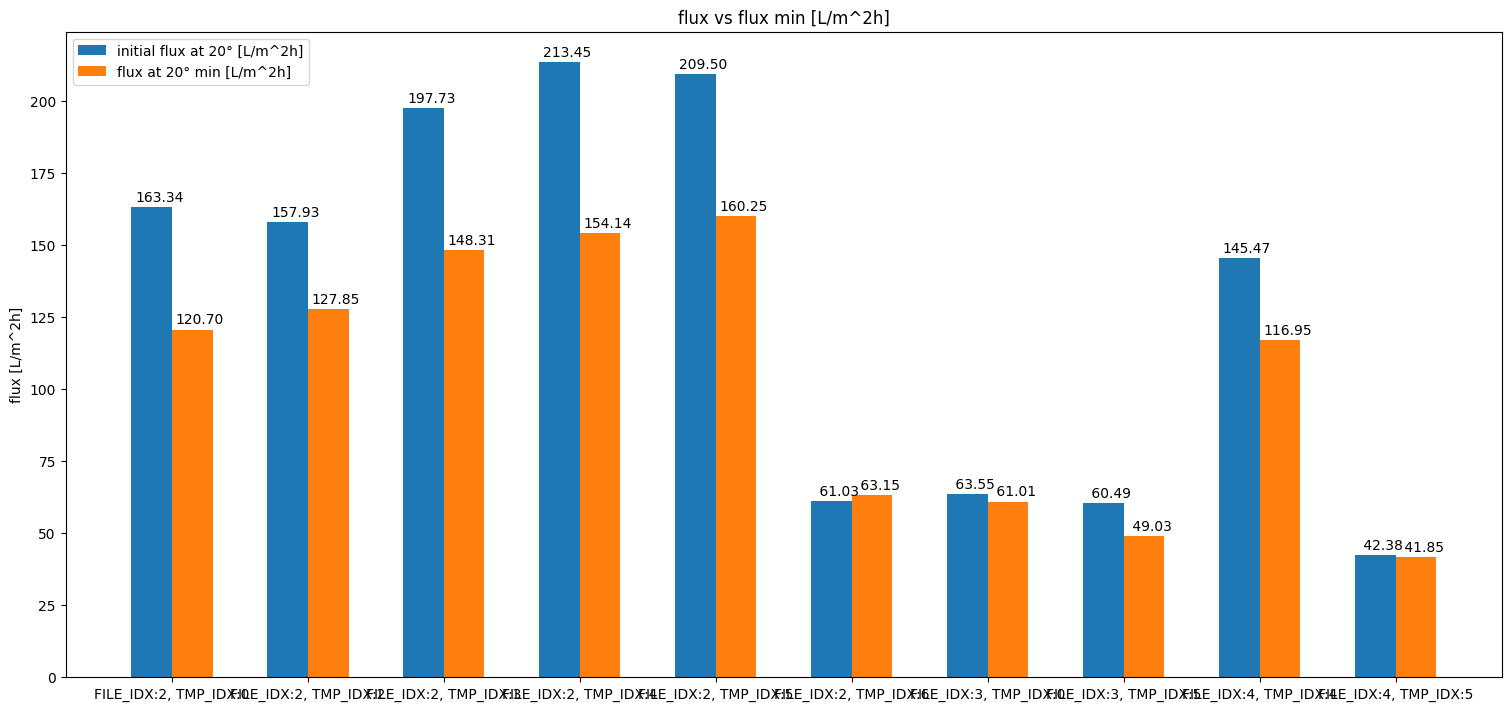

In [132]:
x = np.arange(len(df)) # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plot.subplots(layout='constrained', figsize=(15,7))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

factors = [
    FLUX_COL, FLUX_MIN_COL, #'TMP est [kPa]'
]

for col_name in factors:
    offset = width * multiplier
    label = col_name if col_name != FLUX_COL else f'initial {FLUX_COL}'
    rects = ax.bar(x + offset, df[col_name], width, label=label)
    multiplier += 1

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}".rjust(6, ' '), (p.get_x() + 0.03, p.get_height() + 2))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('flux [L/m^2h]')
ax.set_title('flux vs flux min [L/m^2h]')
ax.set_xticks(x + width/2, df['group'])
ax.legend(loc='upper left', ncols=1)
plot.show()

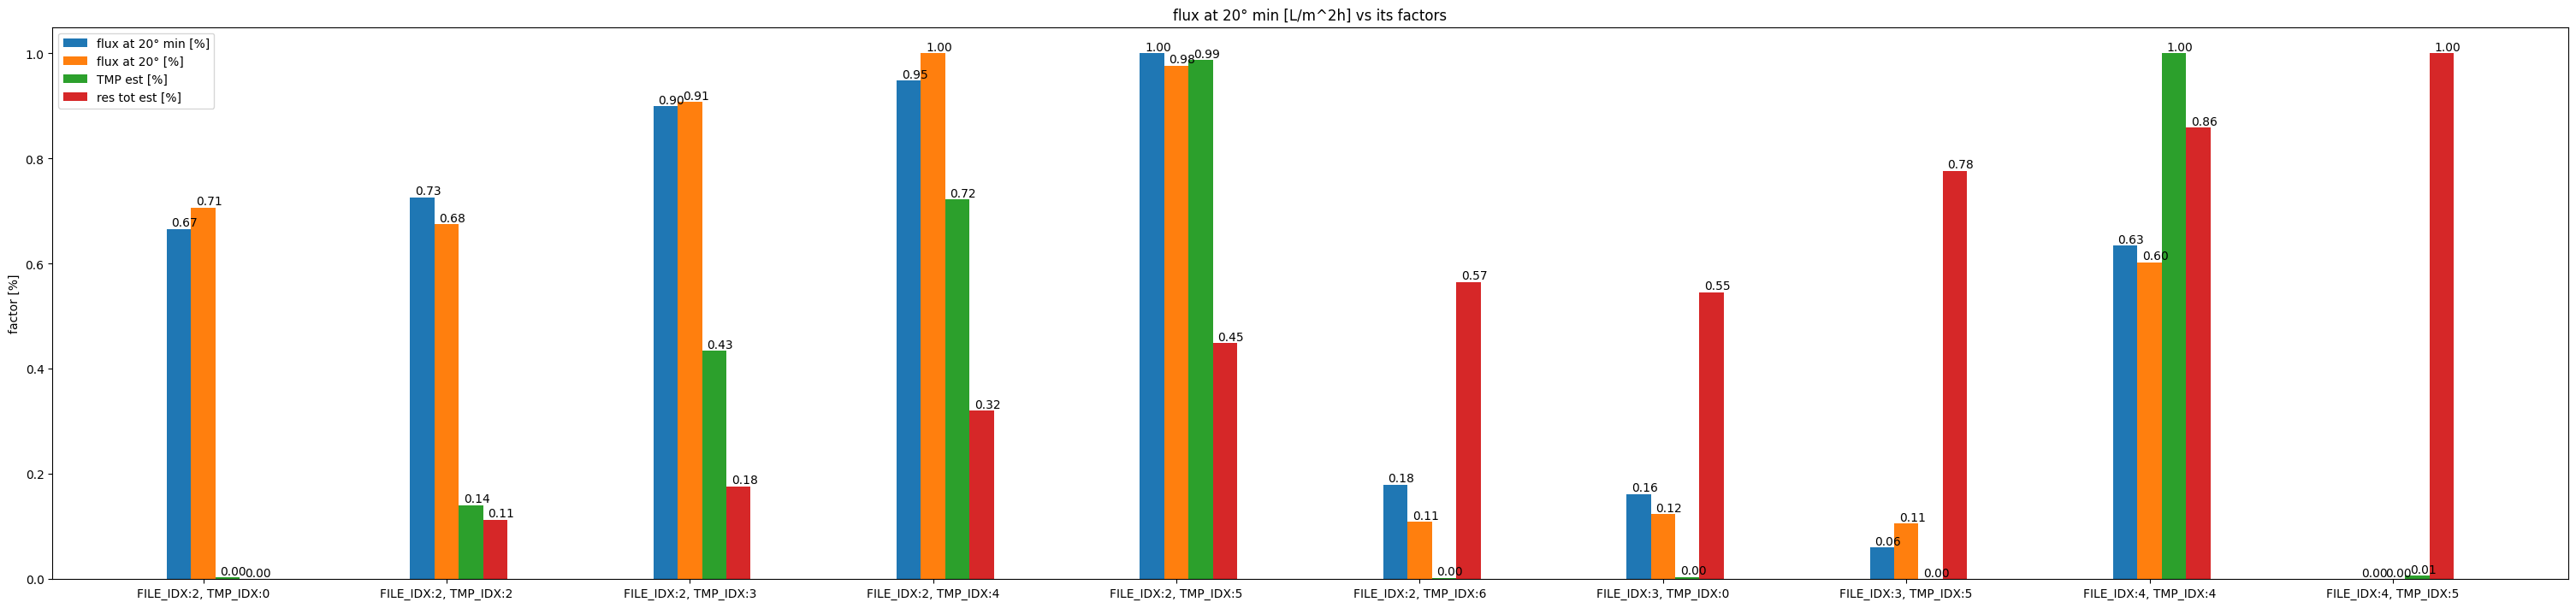

In [133]:
x = np.arange(len(df)) # the label locations
width = 0.1  # the width of the bars
multiplier = 0


fig, ax = plot.subplots(layout='constrained', figsize=(30,7))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

factors = [
    FLUX_MIN_COL, FLUX_COL, 'TMP est [kPa]', 'res tot est [1/m]',
    #'retentate concentration est [g/L]', 'permeate concentration est [g/L]',
]

y_dict, lbls, y_ax_lbl, title = get_y_dict_min_max_cols(df, FLUX_MIN_COL, factors)

for col_name in lbls:
    offset = width * multiplier
    rects = ax.bar(x + offset, df[col_name], width, label=col_name)
    multiplier += 1

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + 0.02, p.get_height() + 0.005))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(y_ax_lbl[1])
ax.set_title(title)
ax.set_xticks(x + (width), df['group'])
ax.legend(loc='upper left', ncols=1)
plot.show()

In [134]:
# df['is clear water'] = (df['initial feed concentration [g/L]'] == 0).astype(int)
#df['is start'] = 0
#df.loc[min(df[df['initial feed concentration [g/L]'] > 0].index),'is start'] = 1

#c = 'retentate concentration est [g/L]'
#df[f'f {c}'] = df[c].apply(lambda x : x**2)

#df[f'f ({FLUX_COL})'] = df[FLUX_COL].apply(lambda x : math.exp(-x))
#df[f'f1 (res tot est [1/m])'] = df['res tot est [1/m]'].apply(lambda x : x**0.33) #x**0.33
#df[f'f2 (res tot est [1/m])'] = df['res tot est [1/m]'].apply(lambda x :  (x/1e14)**2) #(x/1e14)**2
#df[f'f2 (res tot est [1/m])'] = df['res tot est [1/m]'].apply(lambda x :  math.log(x)) #(x/1e14)**2

#f'f1 (res tot est [1/m])',
#f'f2 (res tot est [1/m])',
#'is start',
#'is clear water',
#'is TMP in [100, 200)',
#'f (flux [L/m^2h])',
# f'f {c}',
#'initial feed concentration [g/L]',
#'is TMP in [400, inf)'

In [135]:
factors1 = [ FLUX_COL ]
factors2 = [ FLUX_COL, 'TMP est [kPa]', 'res tot est [1/m]' ]

In [136]:
x1 = df[factors1].dropna()
#print(x)
y1 = df[FLUX_MIN_COL]
model1, y_pred1, intercept1, coeffs1 = call_linear_model(x1, y1, summary=True)
print(f"\np-values:\n{model1.pvalues}\n")
print(get_error_stats(y1, y_pred1, FLUX_MIN_COL))
print()
compute_error_metrics(y1, y_pred1)
df['flux min est-1 [L/m^2h]'] = y_pred1

Variance Inflation Factor (VIF)
 - The model has just one variable, flux at 20° [L/m^2h], thus there can't be multicollinerity.

Intercept:    15.90037586680282
Coefficients: [0.6724932503747343]
                               OLS Regression Results                               
Dep. Variable:     flux at 20° min [L/m^2h]   R-squared:                       0.989
Model:                                  OLS   Adj. R-squared:                  0.987
Method:                       Least Squares   F-statistic:                     695.5
Date:                      Sun, 16 Jun 2024   Prob (F-statistic):           4.59e-09
Time:                              16:04:47   Log-Likelihood:                -29.569
No. Observations:                        10   AIC:                             63.14
Df Residuals:                             8   BIC:                             63.74
Df Model:                                 1                                         
Covariance Type:                  nonro

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [137]:
x2 = df[factors2].dropna()
#print(x)
y2 = df[FLUX_MIN_COL]
model2, y_pred2, intercept2, coeffs2 = call_linear_model(x2, y2, summary=True)
print(f"\np-values:\n{model2.pvalues}\n")
print(get_error_stats(y2, y_pred2, FLUX_MIN_COL))
print()
compute_error_metrics(y2, y_pred2)
df['flux min est-2 [L/m^2h]'] = y_pred2
# set this model as default
df['flux min est [L/m^2h]'] = df['flux min est-2 [L/m^2h]']

Variance Inflation Factor (VIF)
 - flux at 20° [L/m^2h] -> 10.28 ==> Severe multicollinearity, the model coefficients can be poorly estimated
 - TMP est [kPa]        -> 16.91 ==> Severe multicollinearity, the model coefficients can be poorly estimated
 - res tot est [1/m]    ->  4.23 ==> Some multicollinearity

Intercept:    52.720999280910455
Coefficients: [0.4278370026960715, 0.10647671810197559, -3.828397174414207e-12]
                               OLS Regression Results                               
Dep. Variable:     flux at 20° min [L/m^2h]   R-squared:                       0.995
Model:                                  OLS   Adj. R-squared:                  0.992
Method:                       Least Squares   F-statistic:                     387.6
Date:                      Sun, 16 Jun 2024   Prob (F-statistic):           2.95e-07
Time:                              16:04:47   Log-Likelihood:                -25.592
No. Observations:                        10   AIC:              

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


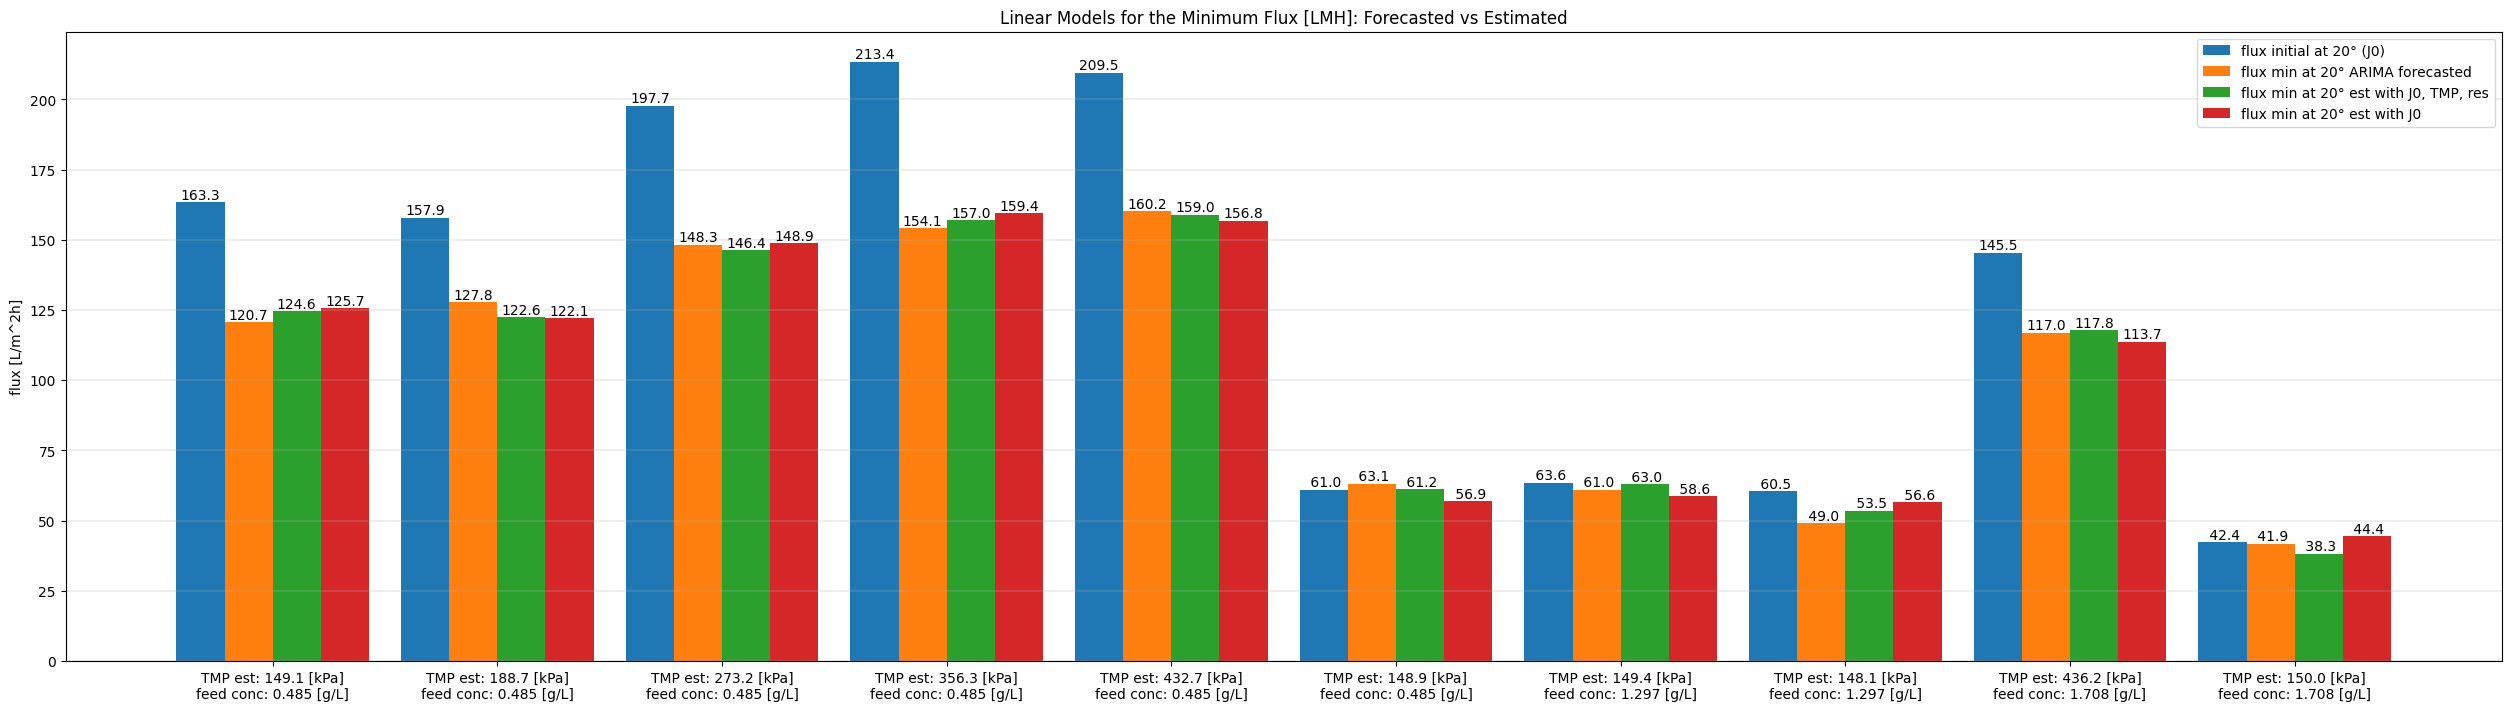

In [138]:
x = np.arange(len(df)) # the label locations

fig, ax = plot.subplots(layout='constrained', figsize=(25,7))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

y_dict = {
    'flux initial at 20° (J0)' : df[FLUX_COL],
    'flux min at 20° ARIMA forecasted' : df[FLUX_MIN_COL],
    'flux min at 20° est with J0, TMP, res'  : df['flux min est-2 [L/m^2h]'],
    'flux min at 20° est with J0'  : df['flux min est-1 [L/m^2h]'],
}

space = 0.2
width = 0.3
tot_width = width * len(y_dict)  # the width of the bars
offset = 0
for (lbl, col) in y_dict.items():
    rects = ax.bar(x * (tot_width + space) + offset, col, width, label=lbl)
    ax.bar_label(rects, fmt='{:5.1f}')
    offset += width

#for p in ax.patches:
#    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + (0.02*len(y_dict)), p.get_height() + 1))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('flux [L/m^2h]')
ax.set_title('Linear Models for the Minimum Flux [LMH]: Forecasted vs Estimated')
ax.set_xticks((tot_width/2) - width/2 + x * (tot_width + space), df['label'], rotation=0)
ax.legend(loc='upper right', ncols=1)
ax.grid(axis='y', lw=0.3)
plot.show()

In [139]:
df_init = df
df = df_bckup

In [140]:
# NOTE :
# flux min est [L/m^2h] is found in df_init with only one row per couple (Conc, TMP)
# flux min pred [L/m^2h] is found in df with all the rows

In [141]:
df['flux min pred [L/m^2h]'] = np.nan
for i in range(len(df_init)) :
    row = df_init.loc[i]
    file_idx = row['file_idx']
    tmp_idx  = row['tmp_idx']
    df['flux min pred [L/m^2h]'] = df.apply(lambda x : row['flux min est [L/m^2h]'] if ((file_idx == x['file_idx']) and (tmp_idx == x['tmp_idx']) and (pd.notna(x['TMP est [kPa]']))) else x['flux min pred [L/m^2h]'], axis=1)

In [142]:
flux_pred_lbl = f"{FLUX_COL} pred"
df[flux_pred_lbl] = np.nan
k = np.nan
bef_k = np.nan
bef_flux = np.nan
new_series = True
for i in range(len(df)) :
    flux_min = df.loc[i, 'flux min pred [L/m^2h]']
    cur_time = df.loc[i, 'time [m]']
    if new_series :
        df.loc[i, flux_pred_lbl] = df.loc[i, FLUX_COL]
        flux_min_pred = flux_min
        flux_min_real = df.loc[i, f'flux at 20° min [L/m^2h]']
        flux_real = df.loc[i, f'flux at 20° [L/m^2h]']
        print("###############################################")
        print(f"file_idx: {df.loc[i, 'file_idx']}, tmp_idx:{df.loc[i, 'tmp_idx']}")
        print(f'flux real: {flux_real:.3f}, flux_min real: {flux_min_real:.3f}, flux_min est: {flux_min_pred:.3f}')
        print(f"time [m]: {df.loc[i,'time [m]']:2.0f}, bef_flux: {bef_flux:.3f}, k: {k:.3f}, flux_min: {flux_min_pred:.3f}, cur_flux real: {df.loc[i,FLUX_COL]:.3f}, cur_flux est: {df.loc[i, flux_pred_lbl]:.3f} ")
        new_series = False
    elif pd.isna(df.loc[i, FLUX_COL]) :
        bef_k = np.nan
        bef_flux = np.nan
        new_series = True
    else :
        bef_flux = df.loc[i-1, flux_pred_lbl]
        k = df.loc[i, 'k(n=2)']
        if pd.notna(k) and k <= 0 :
            k = bef_k
        cur_flux = flux_min if (pd.isna(k) or k == 0.0) else ((bef_flux + k *  flux_min) / (1+k))
        df.loc[i, flux_pred_lbl] = cur_flux
        print(f"time [m]: {df.loc[i,'time [m]']:2.0f}, bef_flux: {bef_flux:.3f}, k: {k:.3f}, flux_min: {flux_min:.3f}, cur_flux real: {df.loc[i,FLUX_COL]:.3f}, cur_flux est: {cur_flux:.3f} ")
        bef_k = k / 1.5

###############################################
file_idx: 2, tmp_idx:0
flux real: 163.337, flux_min real: 120.702, flux_min est: 124.574
time [m]:  0, bef_flux: nan, k: nan, flux_min: 124.574, cur_flux real: 163.337, cur_flux est: 163.337 
time [m]:  1, bef_flux: 163.337, k: 0.590, flux_min: 124.574, cur_flux real: 147.510, cur_flux est: 148.948 
time [m]:  2, bef_flux: 148.948, k: 0.748, flux_min: 124.574, cur_flux real: 136.040, cur_flux est: 138.519 
time [m]:  3, bef_flux: 138.519, k: 0.274, flux_min: 124.574, cur_flux real: 132.740, cur_flux est: 135.519 
time [m]:  4, bef_flux: 135.519, k: 0.472, flux_min: 124.574, cur_flux real: 128.877, cur_flux est: 132.007 
time [m]:  5, bef_flux: 132.007, k: 0.601, flux_min: 124.574, cur_flux real: 125.809, cur_flux est: 129.217 
time [m]:  6, bef_flux: 129.217, k: 0.254, flux_min: 124.574, cur_flux real: 124.775, cur_flux est: 128.277 
time [m]:  7, bef_flux: 128.277, k: 0.254, flux_min: 124.574, cur_flux real: 123.950, cur_flux est: 127.52

In [143]:
df_frcst = df[df['is forecast'] == 1]
df_real  = df[(df['is forecast'] == 0)]
df_init = None
df_est = df
if INITIAL_ADDED :
    df_init = df_real[df_real['is initial'] == 1]
    df_real = df_real[df_real['is initial'] == 0]
    df_est  = df_est[df_est['is initial'] == 0]

   0: feed conc = 0.49 [g/L]
 306: feed conc = 1.30 [g/L]
 408: feed conc = 1.71 [g/L]


Text(0.5, 0, 'time [m]')

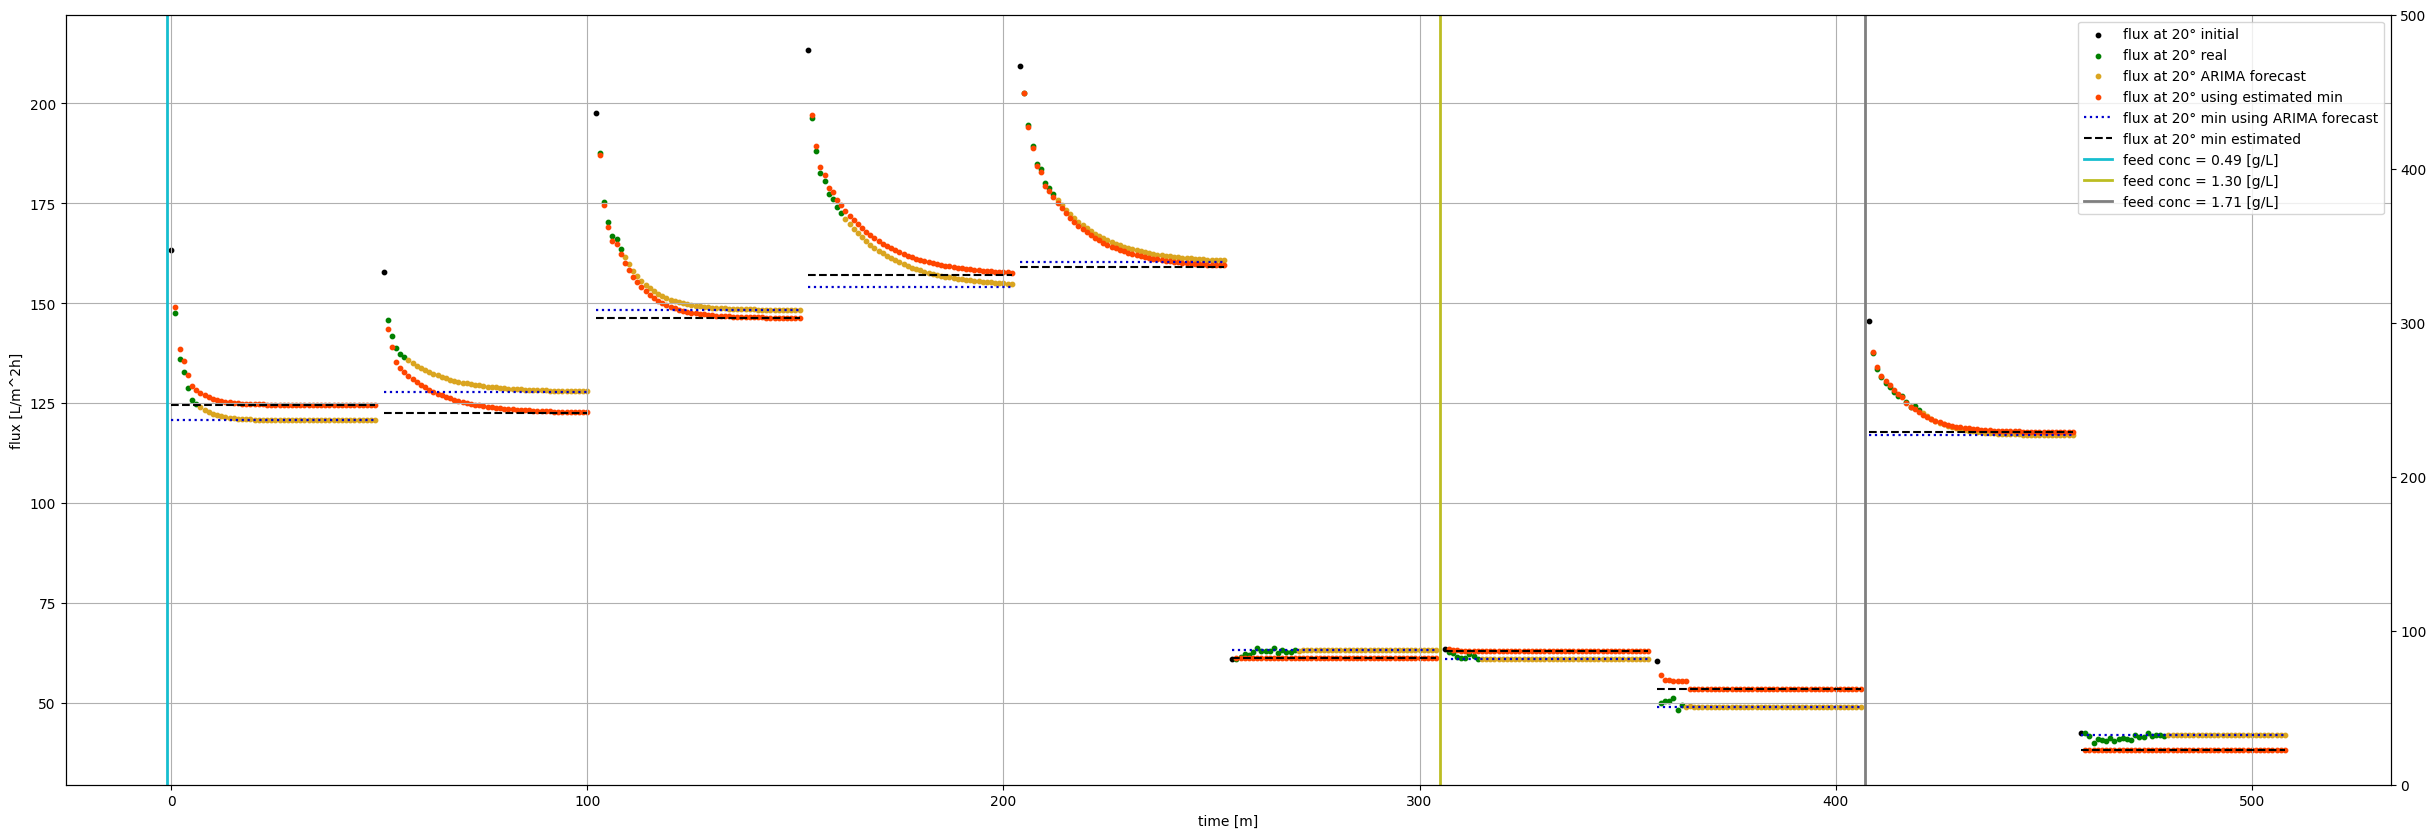

In [144]:
flux = FLUX_COL
#linestyle: ['-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted']
fig, ax1 = plot.subplots(figsize=(30,10))
ax2 = ax1.twinx()
#ax1.plot(   df['index'],       df[flux_pred_lbl],                color='orangered',   marker='o', markersize=0, linestyle='--')
#ax1.plot(   df['index'],       df[flux],                       color='black', marker='o', markersize=0, linestyle=':')

# points
if INITIAL_ADDED :
    ax1.scatter(df_init['index'],  df_init[flux],  color='black', marker='o', s=10, label=f'{FLUX_USED} initial')
ax1.scatter(df_real['index'],  df_real[flux],                   color='green', marker='o', s=10, label=f'{FLUX_USED} real')
ax1.scatter(df_frcst['index'], df_frcst[flux],                  color='goldenrod',  marker='o', s=10, label=f'{FLUX_USED} ARIMA forecast')
ax1.scatter(df_est['index'],   df_est[flux_pred_lbl],                 color='orangered',   marker='o', s=10, label=f'{FLUX_USED} using estimated min')
# lines
ax1.plot(   df['index'],       df[FLUX_MIN_COL],                color='mediumblue',        marker='o', markersize=0, lw=1.6, label=f'{FLUX_USED} min using ARIMA forecast', linestyle='dotted')
ax1.plot(   df['index'],       df['flux min pred [L/m^2h]'],    color='black',        marker='o', markersize=0, lw=1.5, label=f'{FLUX_USED} min estimated', linestyle='dashed')
#ax2.plot(   df['index'],       df['TMP est [kPa]'],             color='hotpink',   marker='o', markersize=0, lw=1.6, label='TMP estimated [kPa]')

conc_lines, conc_lines_GREATER_ZERO = get_concentration_lines(df, time_col='index')
i = len(COLOR_CYCLE) - 1
for (line_x,lbl) in conc_lines.items() :
    ax1.axvline(x=line_x-1, label=lbl, color=COLOR_CYCLE[i], linewidth=2)
    i -= 1

ax1.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')
ax2.set_ylim((0,500))
ax1.set_ylabel('flux [L/m^2h]')
ax1.set_xlabel('time [m]')
#ax2.set_ylabel('pressure [kPa]')
#plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_2.png')

In [145]:
y_col = FLUX_COL
y = df[FLUX_COL].dropna()
y_pred = df[flux_pred_lbl].dropna()
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
print()

        flux at 20° [L/m^2h]  absolute error  relative error  squared error
min                39.858642        0.000000        0.000000       0.000000
median            120.709745        1.996146        0.030789       3.984600
mean              107.800250        2.550028        0.033428       8.737185
max               213.449219        7.294416        0.151110      53.208503
var              2251.716646        2.239020        0.000912      76.340676
std                47.452256        1.496335        0.030200       8.737315

Error metrics:
R^2      0.9961
RMSE     2.9559
MAE      2.5500
MedAE    1.9961
maxAE    7.2944
MAPE     0.0334
maxAPE   0.1511


{'R^2': 0.9961119910652496,
 'RMSE': 2.9558729760420674,
 'MAE': 2.5500280976923735,
 'MedAE': 1.9961462057117316,
 'maxAE': 7.294415849042316,
 'MAPE': 0.03342787189084487,
 'maxAPE': 0.1511098798535168}

In [146]:
write_estimated_coefficients_to_json(FILE_EST_COEFFS, key='flux min', x_cols=factors1, intercept=intercept1, coefficients=coeffs1)